In [1]:
# Task IV - Reduce the Number of Device Statistics to Estimate the
# Service Metric
import pandas as pd
import numpy as np
import sklearn.svm as svm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from pandas_ml import ConfusionMatrix
from scipy.stats.stats import pearsonr
from scipy import stats
from tabulate import tabulate

In [2]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)
X = pd.read_csv('../data/X.csv')
Y = pd.read_csv('../data/Y.csv')

In [3]:
def nmae(y_test, y_pred):
    y_test = pd.DataFrame(y_test)
    y_pred = pd.DataFrame(y_pred)
    
    sum = 0.0
    m = len(y_test)
    average = np.mean(y_test)
    
    for i in range(m):
        sum += abs(y_test.iloc[i, 0] - y_pred.iloc[i, 0])
        i += 1
        
    nmae = (sum / m) / average
    return float(nmae)

In [4]:
# 1. Construct a training set and a test set from the trace as above.
X = X.iloc[:, X.columns != 'TimeStamp']
Y = Y.iloc[:, Y.columns != 'TimeStamp']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3)
lm = linear_model.LinearRegression()

In [5]:
# 2. Method 1: Build all subsets of the feature set X that contain
# either one or two features (i.e., device statistics). Compute the
# models for each of these sets for linear regression over the
# training set.
    
NMAEs = []

for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        if(i == j):
            features = [X_train.columns[i]]
            X_train_subset = pd.DataFrame(X_train, columns=features)
            X_test_subset = pd.DataFrame(X_test, columns=features)
    
            model = lm.fit(X_train_subset, y_train)
            y_pred = lm.predict(X_test_subset)
            
            features_list = str(features).strip('[]')
            subset_nmae = nmae(y_test, y_pred)
            
            NMAEs.append((features_list, subset_nmae))
            
        elif (j > i):
            features = [X_train.columns[i], X_train.columns[j]]  
            X_train_subset = pd.DataFrame(X_train, columns=features)
            X_test_subset = pd.DataFrame(X_test, columns=features)
    
            model = lm.fit(X_train_subset, y_train)
            y_pred = lm.predict(X_test_subset)
            
            features_list = str(features).strip('[]')
            subset_nmae = nmae(y_test, y_pred)
            
            NMAEs.append((features_list, subset_nmae))

# Sort array by NMAE value (asc)
sorted_NMAEs = sorted(NMAEs, key=lambda nmae: nmae[1])

print tabulate(sorted_NMAEs, headers=['Features', 'NMAE (asc)'])

Features                      NMAE (asc)
--------------------------  ------------
'file.nr', 'ldavg.1'            0.105658
'ldavg.1', 'tcpsck'             0.108191
'all_..idle', 'ldavg.1'         0.108193
'ldavg.1', 'pgfree.s'           0.108509
'X..memused', 'ldavg.1'         0.10948
'sum_intr.s', 'ldavg.1'         0.109531
'cswch.s', 'ldavg.1'            0.109538
'proc.s', 'ldavg.1'             0.109543
'ldavg.1'                       0.109547
'cswch.s', 'file.nr'            0.115764
'file.nr', 'tcpsck'             0.116161
'cswch.s', 'tcpsck'             0.120955
'sum_intr.s', 'tcpsck'          0.121007
'file.nr', 'sum_intr.s'         0.123745
'all_..idle', 'file.nr'         0.125789
'X..memused', 'file.nr'         0.127371
'proc.s', 'file.nr'             0.127467
'file.nr'                       0.127524
'file.nr', 'pgfree.s'           0.127542
'tcpsck', 'pgfree.s'            0.128314
'tcpsck'                        0.128458
'proc.s', 'tcpsck'              0.128471
'all_..idle', 'tc

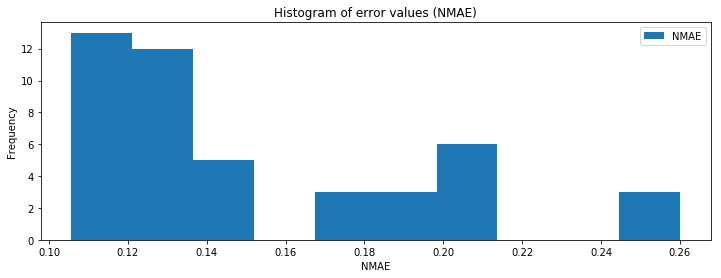

In [6]:
# Plot a histogram of the error values (NMAE) of all the models
# for the test set.

df = pd.DataFrame()
for i in range(len(NMAEs)):
    data = pd.DataFrame({'NMAE': NMAEs[i][1]}, index=[i])
    df = df.append(data)

hist = df.plot.hist(title = 'Histogram of error values (NMAE)')
hist.set_xlabel("NMAE")
fig = hist.get_figure()
plt.show()

In [7]:
# Identify the feature set that produces the model with the
# smallest error and give the device statistic(s) in this set.

# The feature set that produces the model with the smallest error
# is ['file.nr', 'ldavg.1']. The feature 'ldavg.1' is the one that
# contributes the most to obtaining smallest errors since all
# combinations of features with 'ldavg.1' produces NMAE values
# around 0.11.

In [8]:
# 3. Method 2: Linear univariate feature selection. Take each feature
# of X and compute the sample correlation of the feature with the
# corresponding Y value over the training set. The correlation values
# fall into the interval [−1, +1].

In [9]:
SAMPLES = []

for i in range(len(X.columns)):
    features = X.columns[i]
    X_subset = pd.DataFrame(X_train, columns=[features])
    Y_subset = pd.DataFrame(y_train)
    
    r_value = float(pearsonr(X_subset, Y_subset)[0])
    r_squared = float(r_value**2)
    
    SAMPLES.append((features, r_value, r_squared))

print tabulate(SAMPLES, headers=['Feature', 'r_value', 'r_squared'])

Feature       r_value    r_squared
----------  ---------  -----------
all_..idle   0.568078   0.322713
X..memused   0.587781   0.345487
proc.s      -0.227161   0.051602
cswch.s     -0.75792    0.574442
file.nr     -0.787973   0.620902
sum_intr.s   0.511326   0.261454
ldavg.1     -0.841085   0.707425
tcpsck      -0.804682   0.647514
pgfree.s     0.014986   0.00022458


In [10]:
# Rank the features according to the square of the correlation values;
# the top feature has the highest value. Build nine feature sets composed
# of the top k features, k = 1..9. Compute the model for each of these
# nine sets for linear regression over the training set and compute the
# error (NMAE) of these models over the test set. Produce a plot that
# shows the error value in function of the set k.

# Sort samples by r_squared value (desc)
sorted_samples = sorted(SAMPLES, key=lambda sample: sample[2], reverse=True)

print tabulate(sorted_samples, headers=['Feature', 'r_value', 'r_squared'])

Feature       r_value    r_squared
----------  ---------  -----------
ldavg.1     -0.841085   0.707425
tcpsck      -0.804682   0.647514
file.nr     -0.787973   0.620902
cswch.s     -0.75792    0.574442
X..memused   0.587781   0.345487
all_..idle   0.568078   0.322713
sum_intr.s   0.511326   0.261454
proc.s      -0.227161   0.051602
pgfree.s     0.014986   0.00022458


In [11]:
RANK_NMAEs = []

for i in range(len(sorted_samples)):
    samples_subset = sorted_samples[:(i+1)]
    
    k_features = []
    for j in range(len(samples_subset)):
        k_features.insert(j, samples_subset[j][0])
    
    X_train_subset = pd.DataFrame(X_train, columns=k_features)
    X_test_subset = pd.DataFrame(X_test, columns=k_features)
    
    model = lm.fit(X_train_subset, y_train)
    y_pred = lm.predict(X_test_subset)
            
    set_name = 'K[1..' + str(i+1) + ']' if (i > 0) else 'K[1]'
    subset_nmae = nmae(y_test, y_pred)
    
    ks = str(k_features).strip('[]')
    k_features = ks = (ks[:60] + '..') if len(ks) > 60 else ks
    
    RANK_NMAEs.append((set_name, subset_nmae, k_features))
    
print tabulate(RANK_NMAEs, headers=['Set', 'NMAE', 'Features'])

Set          NMAE  Features
-------  --------  --------------------------------------------------------------
K[1]     0.109547  'ldavg.1'
K[1..2]  0.108191  'ldavg.1', 'tcpsck'
K[1..3]  0.105142  'ldavg.1', 'tcpsck', 'file.nr'
K[1..4]  0.105138  'ldavg.1', 'tcpsck', 'file.nr', 'cswch.s'
K[1..5]  0.104516  'ldavg.1', 'tcpsck', 'file.nr', 'cswch.s', 'X..memused'
K[1..6]  0.102304  'ldavg.1', 'tcpsck', 'file.nr', 'cswch.s', 'X..memused', 'al..
K[1..7]  0.102361  'ldavg.1', 'tcpsck', 'file.nr', 'cswch.s', 'X..memused', 'al..
K[1..8]  0.102364  'ldavg.1', 'tcpsck', 'file.nr', 'cswch.s', 'X..memused', 'al..
K[1..9]  0.100632  'ldavg.1', 'tcpsck', 'file.nr', 'cswch.s', 'X..memused', 'al..


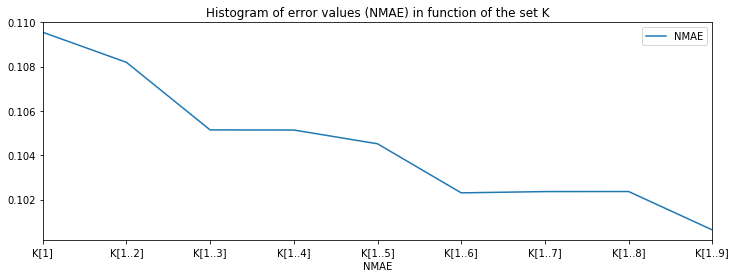

In [12]:
labels = []
df = pd.DataFrame()

for i in range(len(RANK_NMAEs)):
    data = pd.DataFrame({'NMAE': RANK_NMAEs[i][1]}, index=[i])
    labels.append(RANK_NMAEs[i][0])
    df = df.append(data)

series = df.plot(title = 'Histogram of error values (NMAE) in function of the set K')
series.set_xlabel("NMAE")
series.set_xticklabels(labels)
fig = series.get_figure()
plt.show()

In [13]:
# 4. Describe your observations and conclusions.

# The feature that has the lowest NMAE value within the set of device statistics
# X is 'ldavg.1', meaning that is also the most important one to accurately
# predict the value of Y due to its highest degree of accuracy when compared
# to all others. The second method proves how little other features impact
# when they're used along 'ldavg.1' during the regression computation.
# The difference between K[1] and K[1..9] is lower than than 0.01.